You are given two short audio recordings.
 Audio 1 is your own voice saying the word “hello”.
 Audio 2 is your friend’s voice saying the word “hello”.
Your task is to compare these two signals using Dynamic Time Warping.
Tasks for the lab
Record your own voice saying “hello” and store it as Signal 1.


Record your friend saying “hello” and store it as Signal 2.


Convert both audio files into numerical time series by extracting their waveform data.


Normalize both signals so they have comparable amplitude ranges.


Apply Dynamic Time Warping on the two signals.


Produce the alignment path and compute the total DTW distance.


Interpret the results. Explain whether the signals are similar, and describe how DTW helps match two audio patterns that do not align perfectly in time.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.spatial.distance import euclidean
import librosa
import librosa.display
from pydub import AudioSegment
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")
print("\nLibraries used:")
print("  - librosa: Audio processing and feature extraction")
print("  - numpy: Numerical computations")
print("  - matplotlib: Visualization")
print("  - scipy: Distance calculations")

✓ All libraries imported successfully!

Libraries used:
  - librosa: Audio processing and feature extraction
  - numpy: Numerical computations
  - matplotlib: Visualization
  - scipy: Distance calculations


In [2]:
# Load audio files
audio_path_1 = 'mp3/hello1.mp3'
audio_path_2 = 'mp3/hello2.mp3'

print("Loading Audio Files...")
print("=" * 80)

try:
    # Load audio with librosa (automatically converts to mono and resamples)
    signal1, sr1 = librosa.load(audio_path_1, sr=None)
    signal2, sr2 = librosa.load(audio_path_2, sr=None)
    
    print(f"\n✓ Audio 1 (Your Voice):")
    print(f"  - Path: {audio_path_1}")
    print(f"  - Sample Rate: {sr1} Hz")
    print(f"  - Duration: {len(signal1)/sr1:.3f} seconds")
    print(f"  - Number of Samples: {len(signal1)}")
    print(f"  - Shape: {signal1.shape}")
    print(f"  - Data Type: {signal1.dtype}")
    print(f"  - Amplitude Range: [{signal1.min():.4f}, {signal1.max():.4f}]")
    
    print(f"\n✓ Audio 2 (Friend's Voice):")
    print(f"  - Path: {audio_path_2}")
    print(f"  - Sample Rate: {sr2} Hz")
    print(f"  - Duration: {len(signal2)/sr2:.3f} seconds")
    print(f"  - Number of Samples: {len(signal2)}")
    print(f"  - Shape: {signal2.shape}")
    print(f"  - Data Type: {signal2.dtype}")
    print(f"  - Amplitude Range: [{signal2.min():.4f}, {signal2.max():.4f}]")
    
except Exception as e:
    print(f"\n✗ Error loading audio files: {e}")
    print("\nPlease ensure the audio files exist at the specified paths.")

Loading Audio Files...

✓ Audio 1 (Your Voice):
  - Path: mp3/hello1.mp3
  - Sample Rate: 44100 Hz
  - Duration: 1.590 seconds
  - Number of Samples: 70119
  - Shape: (70119,)
  - Data Type: float32
  - Amplitude Range: [-0.3709, 0.2453]

✓ Audio 2 (Friend's Voice):
  - Path: mp3/hello2.mp3
  - Sample Rate: 44100 Hz
  - Duration: 0.710 seconds
  - Number of Samples: 31311
  - Shape: (31311,)
  - Data Type: float32
  - Amplitude Range: [-0.6485, 0.8960]


In [15]:
# ============================================================================
# BLOCK 2: SIGNAL PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("BLOCK 2: SIGNAL PREPROCESSING")
print("="*80)
print("""
THEORY - Signal Preprocessing:

1. Voice Activity Detection (VAD):
   - Remove silence at start and end
   - Focus on actual speech content
   - Threshold-based detection using energy

2. Normalization:
   - Scale amplitudes to [0, 1] or [-1, 1]
   - Makes signals comparable regardless of recording volume
   - Formula: x_norm = (x - min(x)) / (max(x) - min(x))

3. Resampling (if needed):
   - Ensures both signals have same sampling rate
   - Uses interpolation to add/remove samples
   
4. Feature Extraction (optional):
   - Raw waveform vs derived features (MFCC, energy)
   - This lab uses raw waveform for simplicity
""")

def remove_silence(audio, threshold=0.02):
    """
    Remove silence from beginning and end of audio.
    
    Parameters:
    -----------
    audio : ndarray
        Input audio signal
    threshold : float
        Energy threshold for voice activity detection
        
    Returns:
    --------
    trimmed_audio : ndarray
        Audio with silence removed
        
    Theory:
    -------
    Voice Activity Detection (VAD):
    - Compute signal energy in sliding windows
    - Mark frames above threshold as speech
    - Trim continuous silence regions
    """
    # Compute absolute values
    abs_audio = np.abs(audio)
    
    # Find first and last points above threshold
    above_threshold = abs_audio > threshold
    
    if np.any(above_threshold):
        start_idx = np.argmax(above_threshold)
        end_idx = len(audio) - np.argmax(above_threshold[::-1])
        return audio[start_idx:end_idx]
    else:
        return audio

def normalize_signal(signal):
    """
    Normalize signal to range [-1, 1].
    
    Parameters:
    -----------
    signal : ndarray
        Input signal
        
    Returns:
    --------
    normalized : ndarray
        Normalized signal
        
    Theory:
    -------
    Min-Max Normalization:
    x_norm = 2 * (x - min) / (max - min) - 1
    
    Purpose:
    - Remove amplitude bias
    - Make signals comparable
    - Improve DTW distance interpretation
    """
    signal = signal - np.mean(signal)  # Remove DC offset
    max_val = np.max(np.abs(signal))
    if max_val > 0:
        return signal / max_val
    return signal

def preprocess_audio(audio, sample_rate, target_length=None):
    """
    Complete preprocessing pipeline.
    
    Steps:
    1. Remove silence
    2. Normalize amplitude
    3. Optionally resample to target length
    """
    # Remove silence
    audio = remove_silence(audio)
    
    # Normalize
    audio = normalize_signal(audio)
    
    # Resample if needed
    if target_length is not None and len(audio) != target_length:
        audio = resample(audio, target_length)
    
    return audio


BLOCK 2: SIGNAL PREPROCESSING

THEORY - Signal Preprocessing:

1. Voice Activity Detection (VAD):
   - Remove silence at start and end
   - Focus on actual speech content
   - Threshold-based detection using energy

2. Normalization:
   - Scale amplitudes to [0, 1] or [-1, 1]
   - Makes signals comparable regardless of recording volume
   - Formula: x_norm = (x - min(x)) / (max(x) - min(x))

3. Resampling (if needed):
   - Ensures both signals have same sampling rate
   - Uses interpolation to add/remove samples
   
4. Feature Extraction (optional):
   - Raw waveform vs derived features (MFCC, energy)
   - This lab uses raw waveform for simplicity



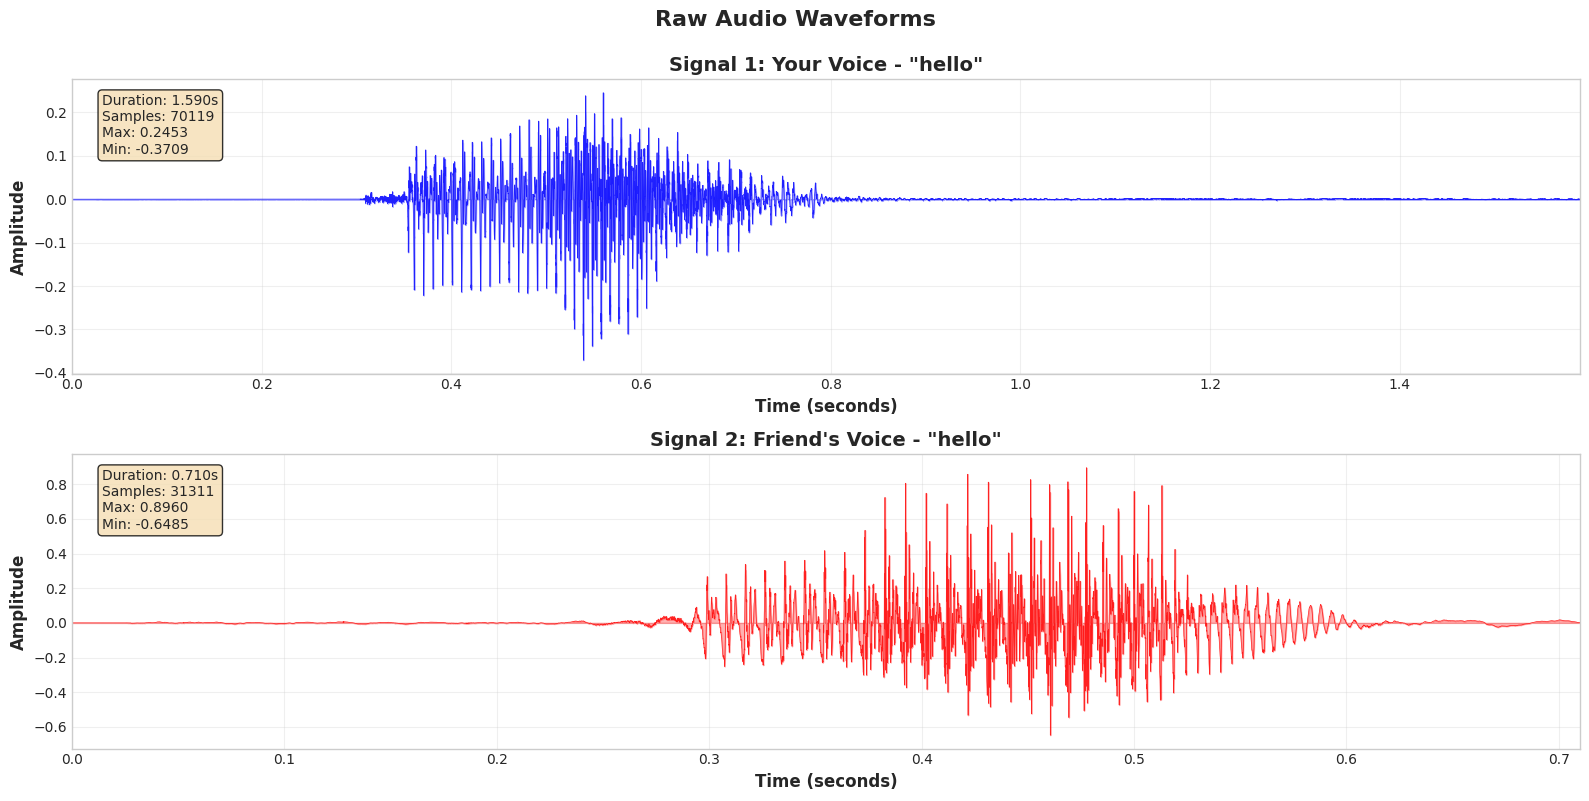


📊 Duration difference: 0.880 seconds
📊 Sample count difference: 38808 samples


In [3]:
# Visualize the raw audio waveforms
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Time arrays
time1 = np.arange(len(signal1)) / sr1
time2 = np.arange(len(signal2)) / sr2

# Plot Signal 1
axes[0].plot(time1, signal1, color='blue', linewidth=0.5, alpha=0.8)
axes[0].fill_between(time1, signal1, alpha=0.3, color='blue')
axes[0].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Amplitude', fontsize=12, fontweight='bold')
axes[0].set_title('Signal 1: Your Voice - "hello"', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, time1[-1])

# Add statistics
axes[0].text(0.02, 0.95, f'Duration: {len(signal1)/sr1:.3f}s\nSamples: {len(signal1)}\nMax: {signal1.max():.4f}\nMin: {signal1.min():.4f}',
            transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot Signal 2
axes[1].plot(time2, signal2, color='red', linewidth=0.5, alpha=0.8)
axes[1].fill_between(time2, signal2, alpha=0.3, color='red')
axes[1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Amplitude', fontsize=12, fontweight='bold')
axes[1].set_title('Signal 2: Friend\'s Voice - "hello"', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, time2[-1])

# Add statistics
axes[1].text(0.02, 0.95, f'Duration: {len(signal2)/sr2:.3f}s\nSamples: {len(signal2)}\nMax: {signal2.max():.4f}\nMin: {signal2.min():.4f}',
            transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('Raw Audio Waveforms', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n📊 Duration difference: {abs(len(signal1)/sr1 - len(signal2)/sr2):.3f} seconds")
print(f"📊 Sample count difference: {abs(len(signal1) - len(signal2))} samples")

In [4]:
# Normalize the signals
print("Normalizing Audio Signals...")
print("=" * 80)

# Method 1: Min-Max Normalization to [-1, 1]
def normalize_minmax(signal):
    """Normalize signal to range [-1, 1]"""
    if np.max(np.abs(signal)) > 0:
        return signal / np.max(np.abs(signal))
    return signal

# Method 2: Z-score normalization
def normalize_zscore(signal):
    """Normalize signal using z-score (mean=0, std=1)"""
    if np.std(signal) > 0:
        return (signal - np.mean(signal)) / np.std(signal)
    return signal - np.mean(signal)

# Apply Min-Max normalization
signal1_normalized = normalize_minmax(signal1)
signal2_normalized = normalize_minmax(signal2)

print("\n✓ Normalization Method: Min-Max to [-1, 1]")
print(f"\nSignal 1 (After Normalization):")
print(f"  - Mean: {np.mean(signal1_normalized):.6f}")
print(f"  - Std Dev: {np.std(signal1_normalized):.6f}")
print(f"  - Range: [{signal1_normalized.min():.6f}, {signal1_normalized.max():.6f}]")

print(f"\nSignal 2 (After Normalization):")
print(f"  - Mean: {np.mean(signal2_normalized):.6f}")
print(f"  - Std Dev: {np.std(signal2_normalized):.6f}")
print(f"  - Range: [{signal2_normalized.min():.6f}, {signal2_normalized.max():.6f}]")

Normalizing Audio Signals...

✓ Normalization Method: Min-Max to [-1, 1]

Signal 1 (After Normalization):
  - Mean: -0.000062
  - Std Dev: 0.094857
  - Range: [-1.000000, 0.661333]

Signal 2 (After Normalization):
  - Mean: 0.000005
  - Std Dev: 0.117333
  - Range: [-0.723837, 1.000000]


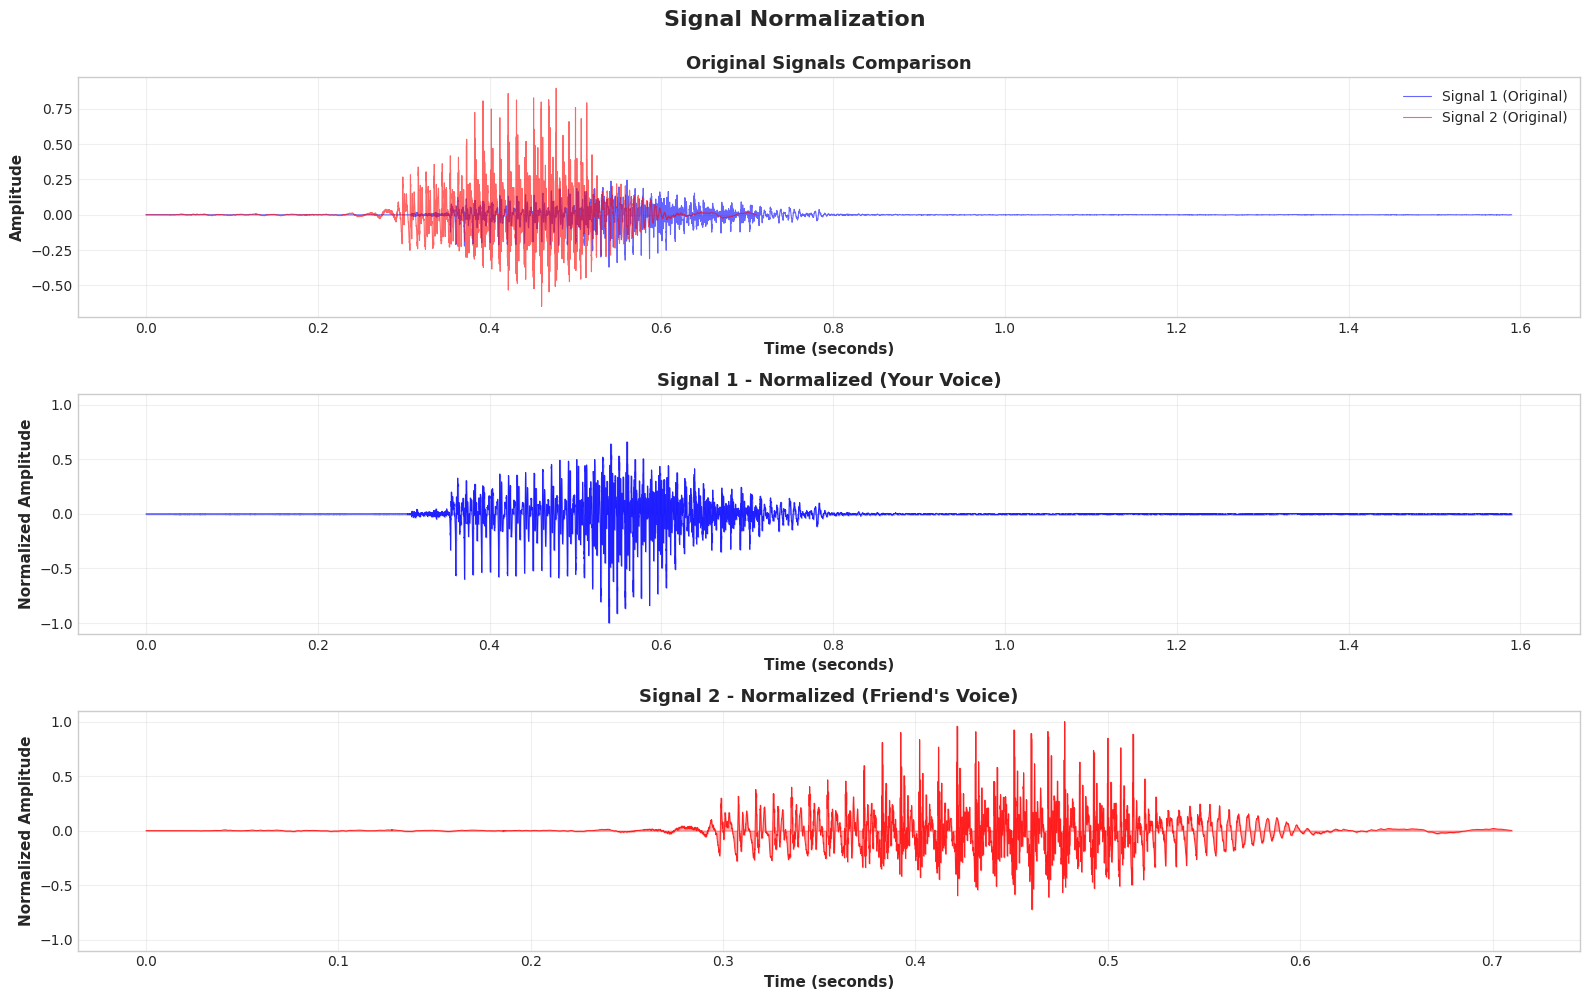

In [5]:
# Visualize normalized signals
fig, axes = plt.subplots(3, 1, figsize=(16, 10))

# Plot original signals comparison
axes[0].plot(time1, signal1, label='Signal 1 (Original)', color='blue', alpha=0.6, linewidth=0.8)
axes[0].plot(time2, signal2, label='Signal 2 (Original)', color='red', alpha=0.6, linewidth=0.8)
axes[0].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[0].set_title('Original Signals Comparison', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot normalized signal 1
axes[1].plot(time1, signal1_normalized, color='blue', linewidth=0.7, alpha=0.8)
axes[1].fill_between(time1, signal1_normalized, alpha=0.3, color='blue')
axes[1].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Normalized Amplitude', fontsize=11, fontweight='bold')
axes[1].set_title('Signal 1 - Normalized (Your Voice)', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-1.1, 1.1)

# Plot normalized signal 2
axes[2].plot(time2, signal2_normalized, color='red', linewidth=0.7, alpha=0.8)
axes[2].fill_between(time2, signal2_normalized, alpha=0.3, color='red')
axes[2].set_xlabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[2].set_ylabel('Normalized Amplitude', fontsize=11, fontweight='bold')
axes[2].set_title('Signal 2 - Normalized (Friend\'s Voice)', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_ylim(-1.1, 1.1)

plt.suptitle('Signal Normalization', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [6]:
# Extract MFCC features for better comparison
print("Extracting MFCC Features...")
print("=" * 80)

# MFCC parameters
n_mfcc = 13  # Number of MFCC coefficients
n_fft = 2048  # FFT window size
hop_length = 512  # Hop length

# Extract MFCCs
mfcc1 = librosa.feature.mfcc(y=signal1_normalized, sr=sr1, n_mfcc=n_mfcc, 
                              n_fft=n_fft, hop_length=hop_length)
mfcc2 = librosa.feature.mfcc(y=signal2_normalized, sr=sr2, n_mfcc=n_mfcc, 
                              n_fft=n_fft, hop_length=hop_length)

# Transpose to have time as first dimension
mfcc1 = mfcc1.T
mfcc2 = mfcc2.T

print(f"\n✓ MFCC Extraction Complete!")
print(f"\nSignal 1 MFCC:")
print(f"  - Shape: {mfcc1.shape} (time_frames x mfcc_coefficients)")
print(f"  - Time frames: {mfcc1.shape[0]}")
print(f"  - MFCC coefficients: {mfcc1.shape[1]}")

print(f"\nSignal 2 MFCC:")
print(f"  - Shape: {mfcc2.shape} (time_frames x mfcc_coefficients)")
print(f"  - Time frames: {mfcc2.shape[0]}")
print(f"  - MFCC coefficients: {mfcc2.shape[1]}")

print(f"\n📊 Frame difference: {abs(mfcc1.shape[0] - mfcc2.shape[0])} frames")

Extracting MFCC Features...

✓ MFCC Extraction Complete!

Signal 1 MFCC:
  - Shape: (137, 13) (time_frames x mfcc_coefficients)
  - Time frames: 137
  - MFCC coefficients: 13

Signal 2 MFCC:
  - Shape: (62, 13) (time_frames x mfcc_coefficients)
  - Time frames: 62
  - MFCC coefficients: 13

📊 Frame difference: 75 frames


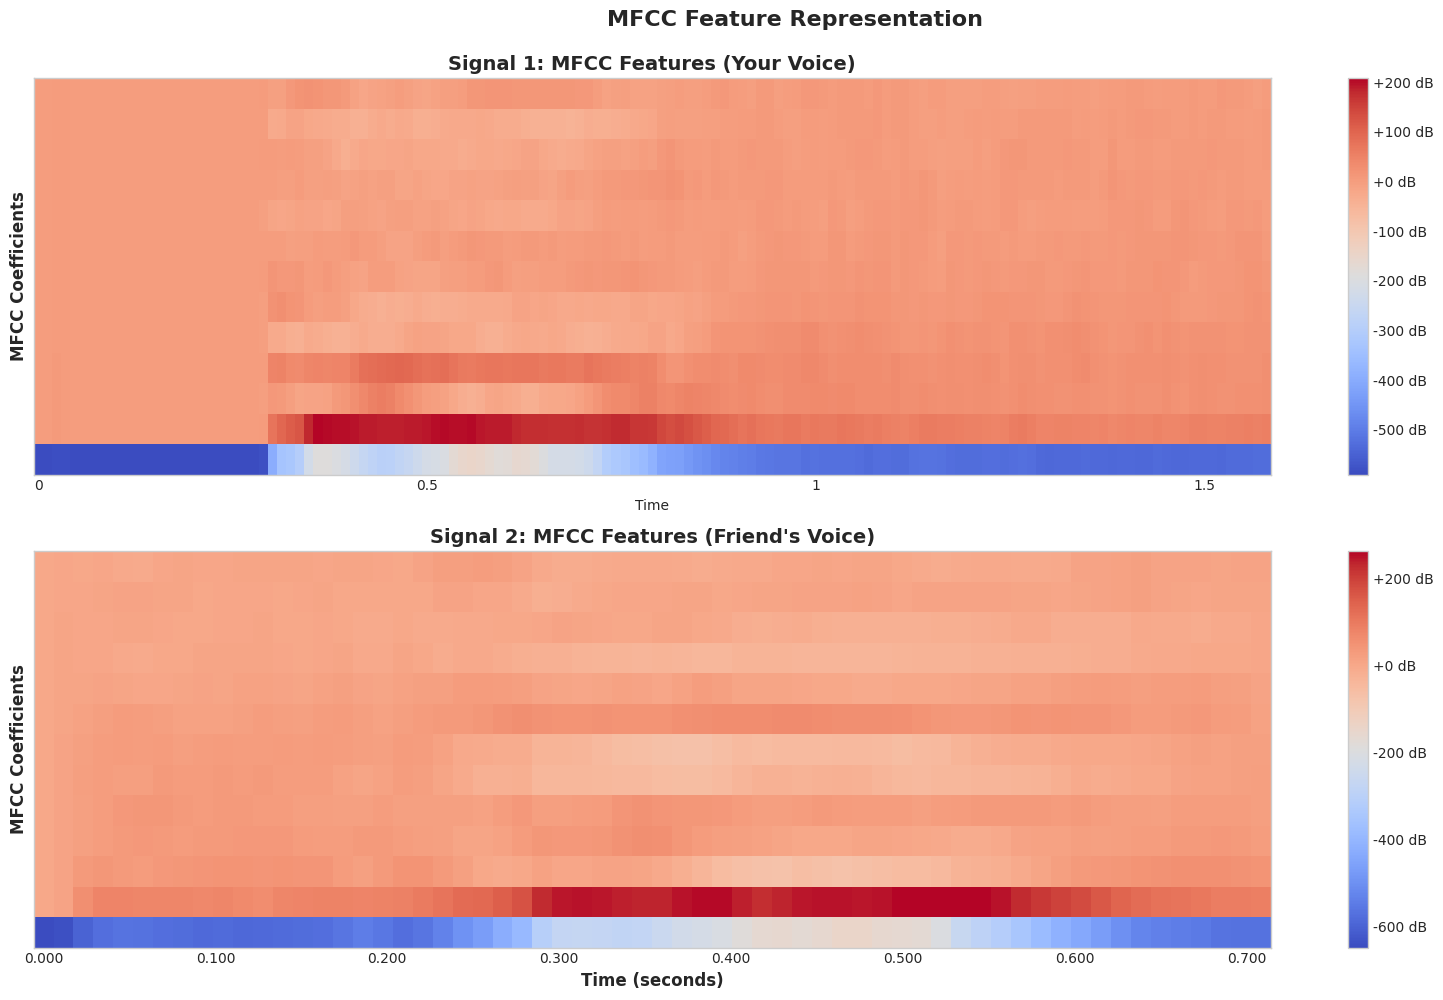

In [7]:
# Visualize MFCC features
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot MFCC 1
img1 = librosa.display.specshow(mfcc1.T, sr=sr1, hop_length=hop_length, 
                                 x_axis='time', ax=axes[0], cmap='coolwarm')
axes[0].set_ylabel('MFCC Coefficients', fontsize=12, fontweight='bold')
axes[0].set_title('Signal 1: MFCC Features (Your Voice)', fontsize=14, fontweight='bold')
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

# Plot MFCC 2
img2 = librosa.display.specshow(mfcc2.T, sr=sr2, hop_length=hop_length, 
                                 x_axis='time', ax=axes[1], cmap='coolwarm')
axes[1].set_ylabel('MFCC Coefficients', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[1].set_title('Signal 2: MFCC Features (Friend\'s Voice)', fontsize=14, fontweight='bold')
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.suptitle('MFCC Feature Representation', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [8]:
# Implement DTW algorithm from scratch
class DynamicTimeWarping:
    """
    Dynamic Time Warping implementation for time series alignment
    """
    
    def __init__(self, distance_metric='euclidean'):
        self.distance_metric = distance_metric
        self.cost_matrix = None
        self.accumulated_cost = None
        self.path = None
        
    def compute_distance(self, x, y):
        """Compute distance between two points"""
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(x - y)
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x - y))
        elif self.distance_metric == 'squared':
            return np.sum((x - y) ** 2)
        else:
            return np.linalg.norm(x - y)
    
    def compute_cost_matrix(self, seq1, seq2):
        """Compute the cost matrix between two sequences"""
        n, m = len(seq1), len(seq2)
        self.cost_matrix = np.zeros((n, m))
        
        # Compute pairwise distances
        for i in range(n):
            for j in range(m):
                self.cost_matrix[i, j] = self.compute_distance(seq1[i], seq2[j])
        
        return self.cost_matrix
    
    def compute_accumulated_cost(self, seq1, seq2):
        """Compute the accumulated cost matrix"""
        n, m = len(seq1), len(seq2)
        
        # Compute cost matrix if not already computed
        if self.cost_matrix is None:
            self.compute_cost_matrix(seq1, seq2)
        
        # Initialize accumulated cost matrix
        self.accumulated_cost = np.zeros((n, m))
        self.accumulated_cost[0, 0] = self.cost_matrix[0, 0]
        
        # Fill first row
        for j in range(1, m):
            self.accumulated_cost[0, j] = self.accumulated_cost[0, j-1] + self.cost_matrix[0, j]
        
        # Fill first column
        for i in range(1, n):
            self.accumulated_cost[i, 0] = self.accumulated_cost[i-1, 0] + self.cost_matrix[i, 0]
        
        # Fill the rest of the matrix
        for i in range(1, n):
            for j in range(1, m):
                min_cost = min(
                    self.accumulated_cost[i-1, j],      # Insertion
                    self.accumulated_cost[i, j-1],      # Deletion
                    self.accumulated_cost[i-1, j-1]     # Match
                )
                self.accumulated_cost[i, j] = self.cost_matrix[i, j] + min_cost
        
        return self.accumulated_cost
    
    def find_optimal_path(self):
        """Backtrack to find the optimal warping path"""
        if self.accumulated_cost is None:
            raise ValueError("Must compute accumulated cost first")
        
        n, m = self.accumulated_cost.shape
        i, j = n - 1, m - 1
        path = [(i, j)]
        
        while i > 0 or j > 0:
            if i == 0:
                j -= 1
            elif j == 0:
                i -= 1
            else:
                # Find minimum of three neighbors
                costs = [
                    self.accumulated_cost[i-1, j-1],  # Diagonal
                    self.accumulated_cost[i-1, j],    # Up
                    self.accumulated_cost[i, j-1]     # Left
                ]
                min_idx = np.argmin(costs)
                
                if min_idx == 0:
                    i, j = i-1, j-1
                elif min_idx == 1:
                    i = i-1
                else:
                    j = j-1
            
            path.append((i, j))
        
        self.path = path[::-1]  # Reverse to get path from start to end
        return self.path
    
    def compute_dtw(self, seq1, seq2):
        """Compute complete DTW: cost matrix, accumulated cost, and path"""
        self.compute_accumulated_cost(seq1, seq2)
        self.find_optimal_path()
        dtw_distance = self.accumulated_cost[-1, -1]
        
        return dtw_distance, self.path

# Create DTW instance
dtw = DynamicTimeWarping(distance_metric='euclidean')

print("✓ Dynamic Time Warping Algorithm Implemented!")
print("\nDTW Components:")
print("  - Distance Metric: Euclidean")
print("  - Cost Matrix Computation")
print("  - Accumulated Cost Matrix")
print("  - Optimal Path Finding (Backtracking)")

✓ Dynamic Time Warping Algorithm Implemented!

DTW Components:
  - Distance Metric: Euclidean
  - Cost Matrix Computation
  - Accumulated Cost Matrix
  - Optimal Path Finding (Backtracking)


In [9]:
# Apply DTW on downsampled raw audio signals
print("Applying DTW on Raw Audio Signals...")
print("=" * 80)

# Downsample signals for computational efficiency
downsample_factor = 100
signal1_downsampled = signal1_normalized[::downsample_factor].reshape(-1, 1)
signal2_downsampled = signal2_normalized[::downsample_factor].reshape(-1, 1)

print(f"\nDownsampled Signal Shapes:")
print(f"  - Signal 1: {signal1_downsampled.shape}")
print(f"  - Signal 2: {signal2_downsampled.shape}")

# Compute DTW
dtw_audio = DynamicTimeWarping(distance_metric='euclidean')
dtw_distance_audio, dtw_path_audio = dtw_audio.compute_dtw(signal1_downsampled, signal2_downsampled)

print(f"\n✓ DTW Computation Complete (Raw Audio)!")
print(f"\nResults:")
print(f"  - DTW Distance: {dtw_distance_audio:.4f}")
print(f"  - Normalized DTW Distance: {dtw_distance_audio / len(dtw_path_audio):.4f}")
print(f"  - Alignment Path Length: {len(dtw_path_audio)}")
print(f"  - Cost Matrix Shape: {dtw_audio.cost_matrix.shape}")
print(f"  - Accumulated Cost Matrix Shape: {dtw_audio.accumulated_cost.shape}")

Applying DTW on Raw Audio Signals...

Downsampled Signal Shapes:
  - Signal 1: (702, 1)
  - Signal 2: (314, 1)

✓ DTW Computation Complete (Raw Audio)!

Results:
  - DTW Distance: 19.3327
  - Normalized DTW Distance: 0.0240
  - Alignment Path Length: 807
  - Cost Matrix Shape: (702, 314)
  - Accumulated Cost Matrix Shape: (702, 314)


In [10]:
# Apply DTW on MFCC features (more robust)
print("\nApplying DTW on MFCC Features...")
print("=" * 80)

# Compute DTW on MFCC features
dtw_mfcc = DynamicTimeWarping(distance_metric='euclidean')
dtw_distance_mfcc, dtw_path_mfcc = dtw_mfcc.compute_dtw(mfcc1, mfcc2)

print(f"\n✓ DTW Computation Complete (MFCC Features)!")
print(f"\nResults:")
print(f"  - DTW Distance: {dtw_distance_mfcc:.4f}")
print(f"  - Normalized DTW Distance: {dtw_distance_mfcc / len(dtw_path_mfcc):.4f}")
print(f"  - Alignment Path Length: {len(dtw_path_mfcc)}")
print(f"  - Cost Matrix Shape: {dtw_mfcc.cost_matrix.shape}")
print(f"  - Accumulated Cost Matrix Shape: {dtw_mfcc.accumulated_cost.shape}")

# Calculate additional metrics
path_array = np.array(dtw_path_mfcc)
diagonal_distance = np.sum(np.abs(path_array[:, 0] - path_array[:, 1]))

print(f"\nAdditional Metrics:")
print(f"  - Path Deviation from Diagonal: {diagonal_distance}")
print(f"  - Average Step Size: {len(dtw_path_mfcc) / max(mfcc1.shape[0], mfcc2.shape[0]):.4f}")


Applying DTW on MFCC Features...

✓ DTW Computation Complete (MFCC Features)!

Results:
  - DTW Distance: 12841.0224
  - Normalized DTW Distance: 93.7301
  - Alignment Path Length: 137
  - Cost Matrix Shape: (137, 62)
  - Accumulated Cost Matrix Shape: (137, 62)

Additional Metrics:
  - Path Deviation from Diagonal: 3520
  - Average Step Size: 1.0000


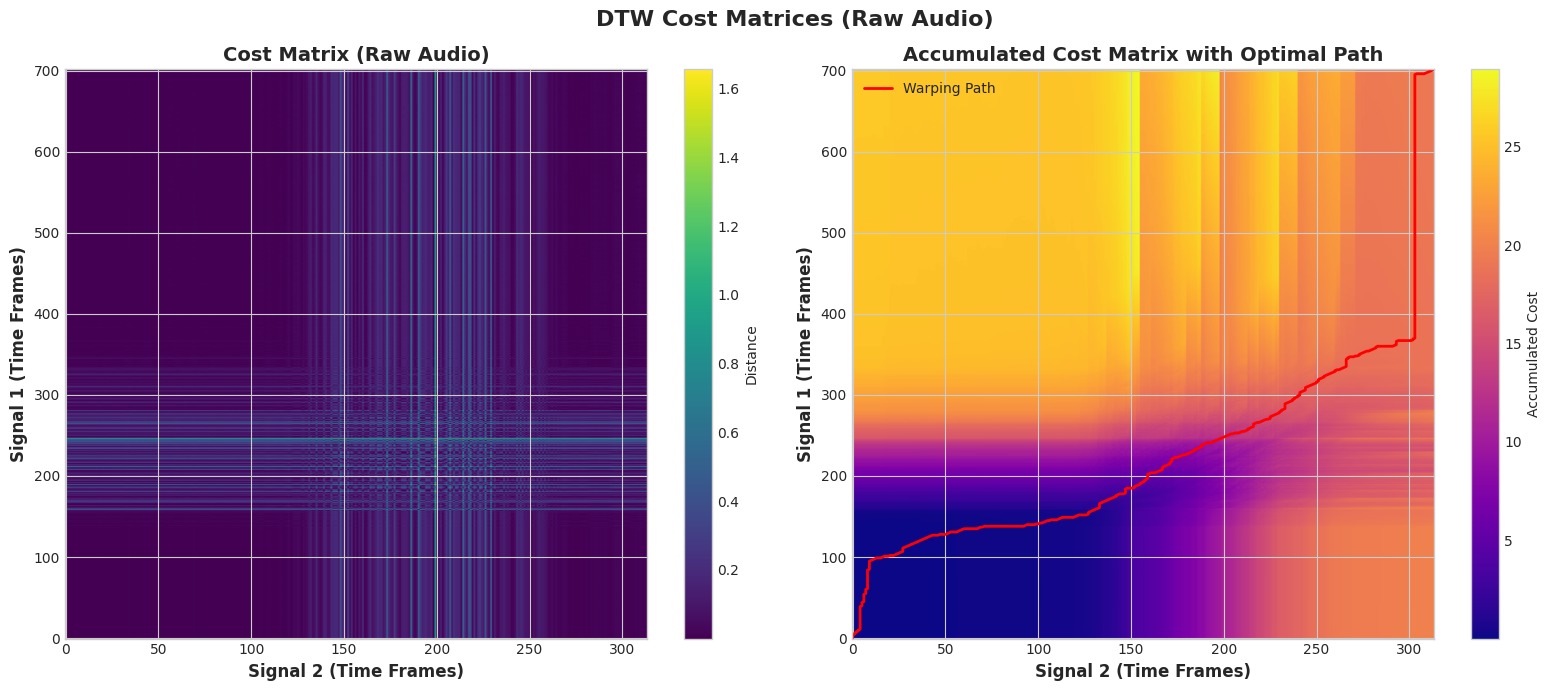

In [12]:
# Visualize cost matrix for raw audio
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot cost matrix
im1 = axes[0].imshow(dtw_audio.cost_matrix, cmap='viridis', aspect='auto', origin='lower')
axes[0].set_xlabel('Signal 2 (Time Frames)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Signal 1 (Time Frames)', fontsize=12, fontweight='bold')
axes[0].set_title('Cost Matrix (Raw Audio)', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Distance')

# Plot accumulated cost matrix with path
im2 = axes[1].imshow(dtw_audio.accumulated_cost, cmap='plasma', aspect='auto', origin='lower')
axes[1].set_xlabel('Signal 2 (Time Frames)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Signal 1 (Time Frames)', fontsize=12, fontweight='bold')
axes[1].set_title('Accumulated Cost Matrix with Optimal Path', fontsize=14, fontweight='bold')

# Plot the warping path
path_array = np.array(dtw_path_audio)
axes[1].plot(path_array[:, 1], path_array[:, 0], color='red', linewidth=2, label='Warping Path')
axes[1].legend(loc='upper left', fontsize=10)
plt.colorbar(im2, ax=axes[1], label='Accumulated Cost')

plt.suptitle('DTW Cost Matrices (Raw Audio)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

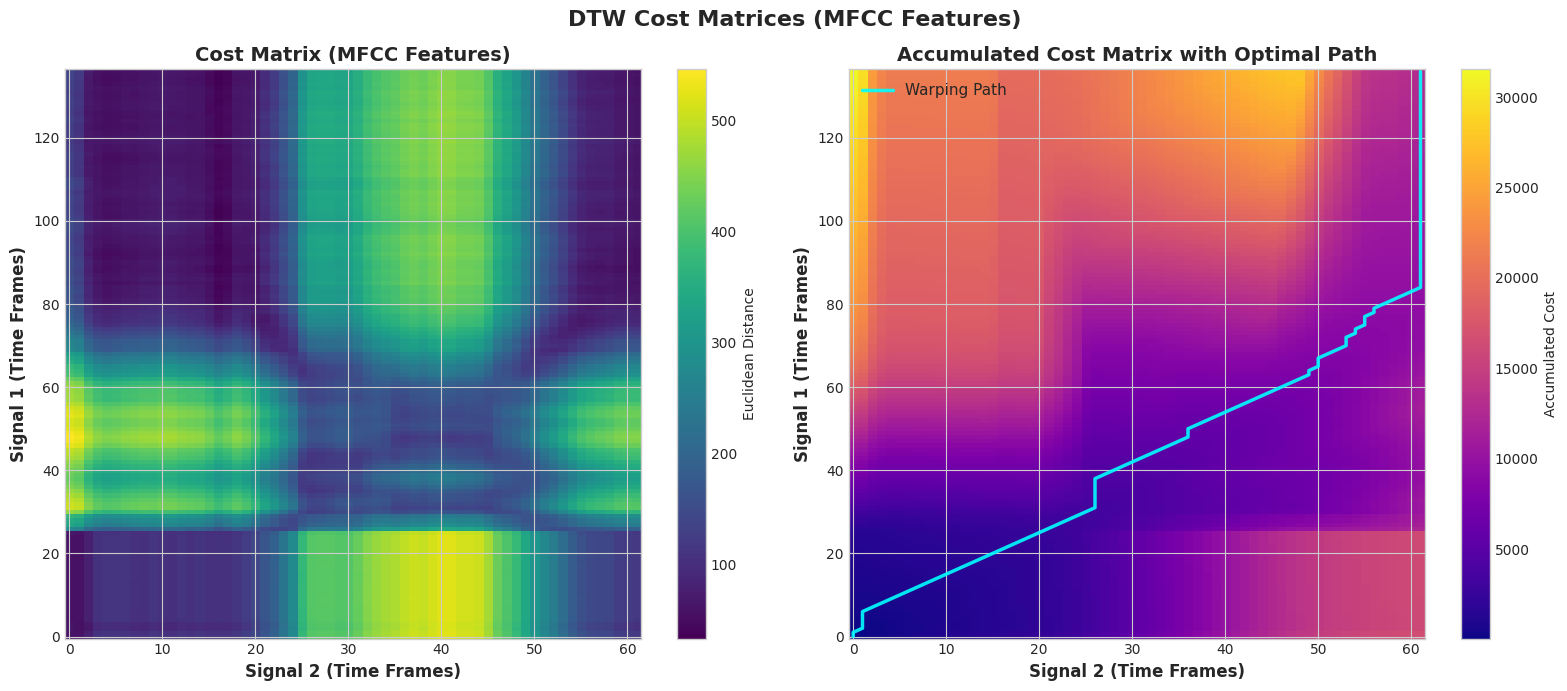

In [13]:
# Visualize cost matrix for MFCC features
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot cost matrix
im1 = axes[0].imshow(dtw_mfcc.cost_matrix, cmap='viridis', aspect='auto', origin='lower')
axes[0].set_xlabel('Signal 2 (Time Frames)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Signal 1 (Time Frames)', fontsize=12, fontweight='bold')
axes[0].set_title('Cost Matrix (MFCC Features)', fontsize=14, fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Euclidean Distance')

# Plot accumulated cost matrix with path
im2 = axes[1].imshow(dtw_mfcc.accumulated_cost, cmap='plasma', aspect='auto', origin='lower')
axes[1].set_xlabel('Signal 2 (Time Frames)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Signal 1 (Time Frames)', fontsize=12, fontweight='bold')
axes[1].set_title('Accumulated Cost Matrix with Optimal Path', fontsize=14, fontweight='bold')

# Plot the warping path
path_array_mfcc = np.array(dtw_path_mfcc)
axes[1].plot(path_array_mfcc[:, 1], path_array_mfcc[:, 0], 
            color='cyan', linewidth=2.5, label='Warping Path', alpha=0.9)
axes[1].legend(loc='upper left', fontsize=11)
plt.colorbar(im2, ax=axes[1], label='Accumulated Cost')

plt.suptitle('DTW Cost Matrices (MFCC Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

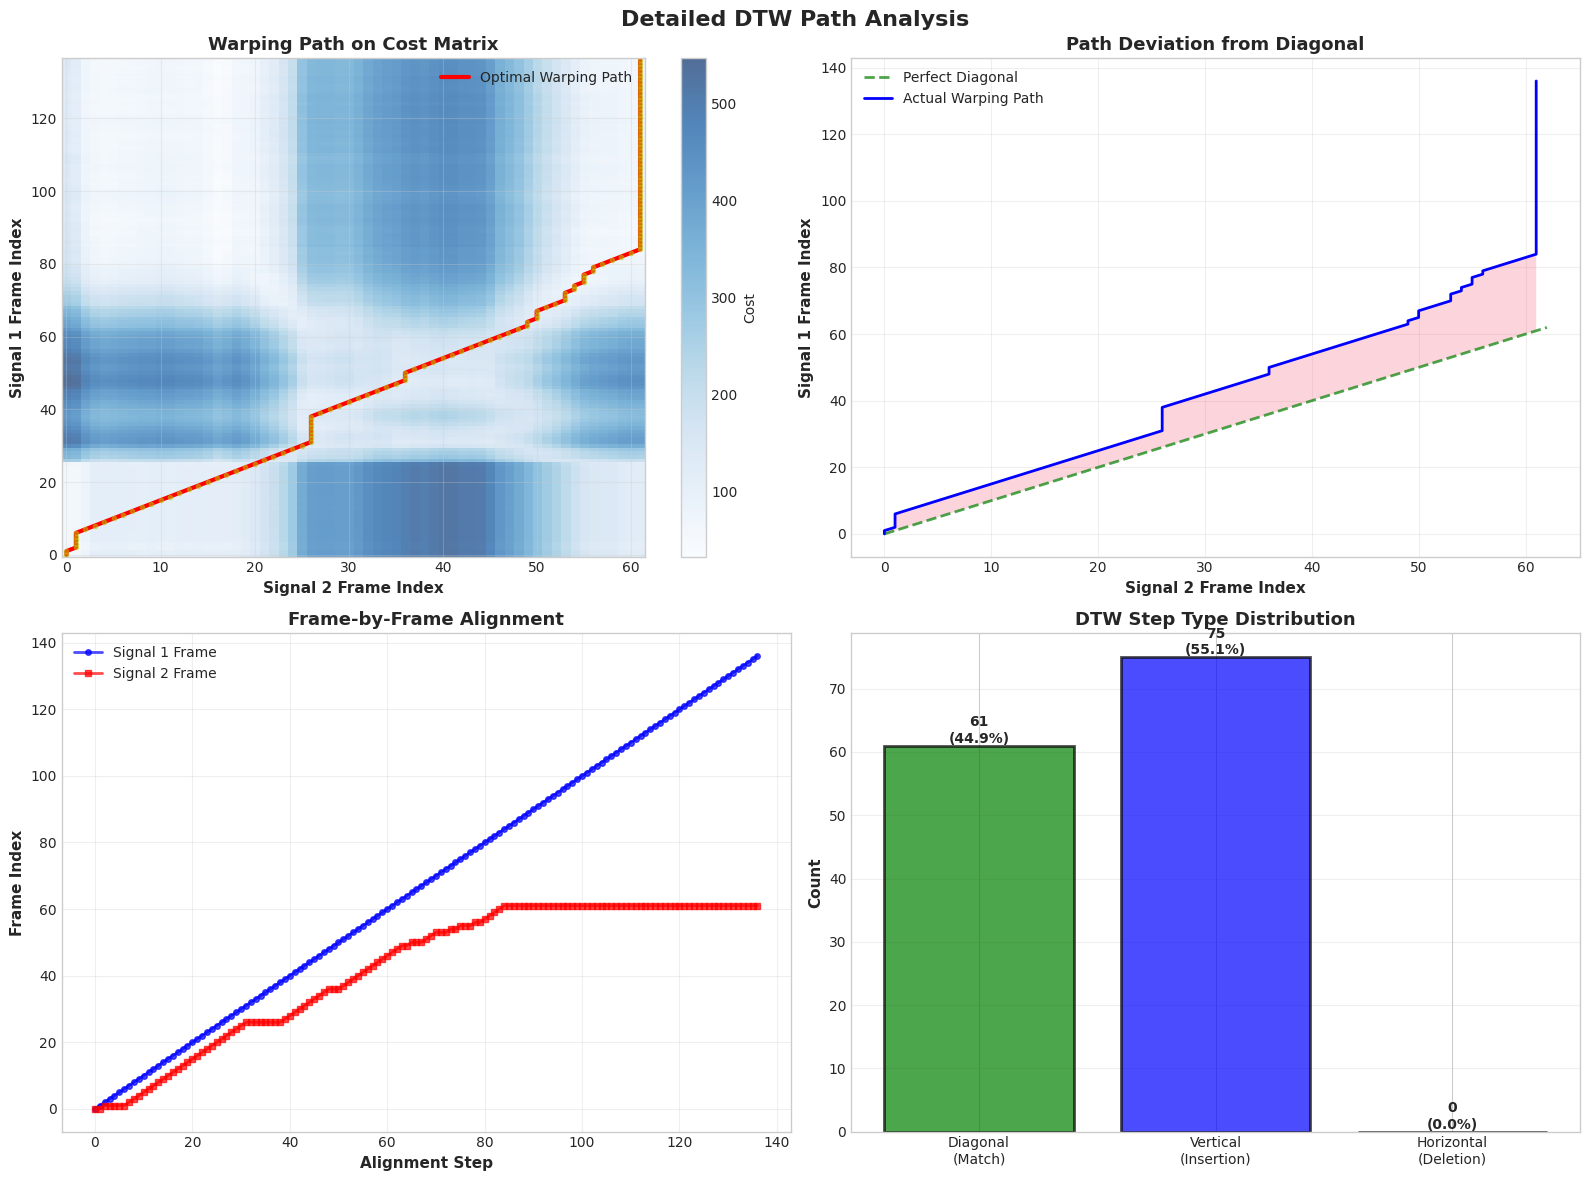


Path Statistics:
  - Diagonal steps (matches): 61 (44.9%)
  - Vertical steps (insertions): 75 (55.1%)
  - Horizontal steps (deletions): 0 (0.0%)


In [14]:
# Detailed visualization of the warping path
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Warping path on cost matrix
ax1 = axes[0, 0]
im1 = ax1.imshow(dtw_mfcc.cost_matrix, cmap='Blues', aspect='auto', origin='lower', alpha=0.7)
ax1.plot(path_array_mfcc[:, 1], path_array_mfcc[:, 0], 
        'r-', linewidth=3, label='Optimal Warping Path')
ax1.plot(path_array_mfcc[:, 1], path_array_mfcc[:, 0], 
        'yo', markersize=3, alpha=0.5)
ax1.set_xlabel('Signal 2 Frame Index', fontsize=11, fontweight='bold')
ax1.set_ylabel('Signal 1 Frame Index', fontsize=11, fontweight='bold')
ax1.set_title('Warping Path on Cost Matrix', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
plt.colorbar(im1, ax=ax1, label='Cost')

# Plot 2: Path deviation from diagonal
ax2 = axes[0, 1]
diagonal_line = np.linspace(0, min(mfcc1.shape[0], mfcc2.shape[0]), 100)
ax2.plot(diagonal_line, diagonal_line, 'g--', linewidth=2, label='Perfect Diagonal', alpha=0.7)
ax2.plot(path_array_mfcc[:, 1], path_array_mfcc[:, 0], 
        'b-', linewidth=2, label='Actual Warping Path')
ax2.fill_between(path_array_mfcc[:, 1], path_array_mfcc[:, 0], 
                 path_array_mfcc[:, 1], alpha=0.3)
ax2.set_xlabel('Signal 2 Frame Index', fontsize=11, fontweight='bold')
ax2.set_ylabel('Signal 1 Frame Index', fontsize=11, fontweight='bold')
ax2.set_title('Path Deviation from Diagonal', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Frame-by-frame alignment
ax3 = axes[1, 0]
frame_indices = np.arange(len(dtw_path_mfcc))
ax3.plot(frame_indices, path_array_mfcc[:, 0], 'b-', linewidth=2, 
        marker='o', markersize=4, label='Signal 1 Frame', alpha=0.7)
ax3.plot(frame_indices, path_array_mfcc[:, 1], 'r-', linewidth=2, 
        marker='s', markersize=4, label='Signal 2 Frame', alpha=0.7)
ax3.set_xlabel('Alignment Step', fontsize=11, fontweight='bold')
ax3.set_ylabel('Frame Index', fontsize=11, fontweight='bold')
ax3.set_title('Frame-by-Frame Alignment', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Step sizes in the path
ax4 = axes[1, 1]
step_types = []
for i in range(1, len(dtw_path_mfcc)):
    di = path_array_mfcc[i, 0] - path_array_mfcc[i-1, 0]
    dj = path_array_mfcc[i, 1] - path_array_mfcc[i-1, 1]
    if di == 1 and dj == 1:
        step_types.append(0)  # Diagonal
    elif di == 1 and dj == 0:
        step_types.append(1)  # Vertical
    else:
        step_types.append(2)  # Horizontal

step_counts = [step_types.count(i) for i in range(3)]
step_labels = ['Diagonal\n(Match)', 'Vertical\n(Insertion)', 'Horizontal\n(Deletion)']
colors = ['green', 'blue', 'red']

bars = ax4.bar(step_labels, step_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_ylabel('Count', fontsize=11, fontweight='bold')
ax4.set_title('DTW Step Type Distribution', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, step_counts):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/sum(step_counts)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Detailed DTW Path Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nPath Statistics:")
print(f"  - Diagonal steps (matches): {step_counts[0]} ({step_counts[0]/sum(step_counts)*100:.1f}%)")
print(f"  - Vertical steps (insertions): {step_counts[1]} ({step_counts[1]/sum(step_counts)*100:.1f}%)")
print(f"  - Horizontal steps (deletions): {step_counts[2]} ({step_counts[2]/sum(step_counts)*100:.1f}%)")

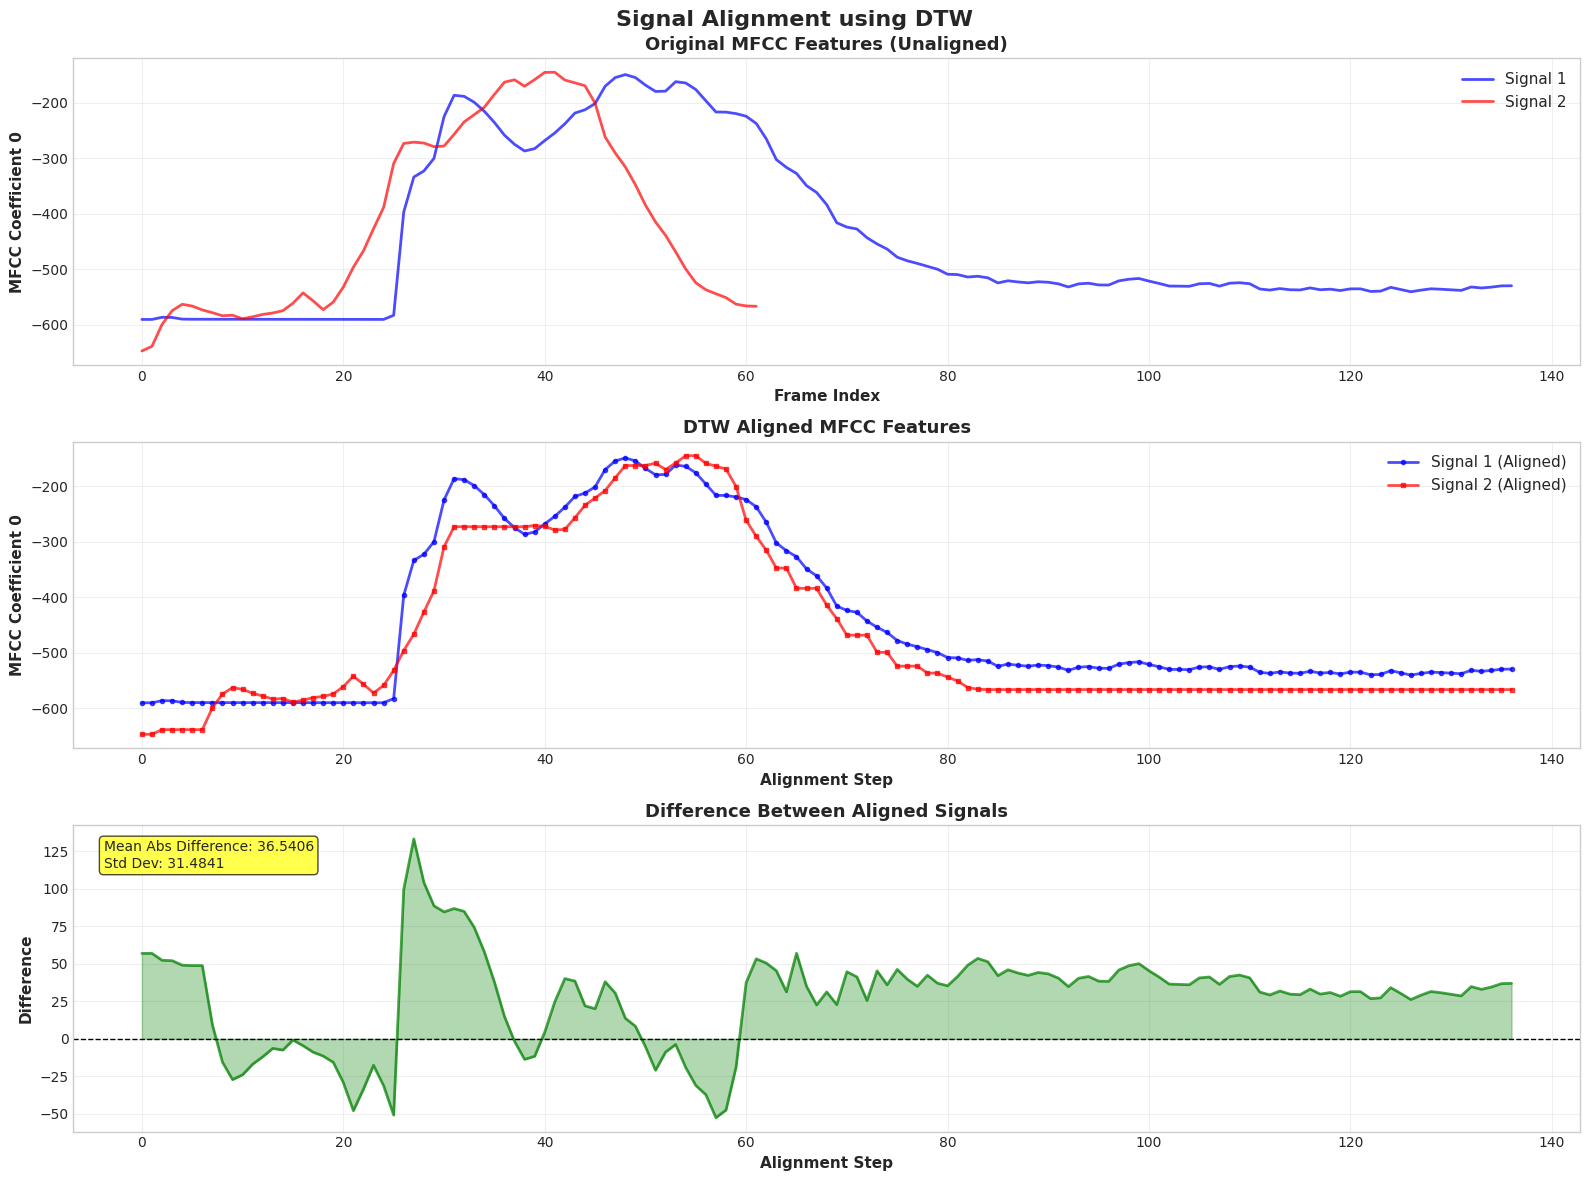

In [16]:
# Visualize aligned signals using DTW path
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Extract aligned segments based on DTW path
aligned_indices1 = path_array_mfcc[:, 0]
aligned_indices2 = path_array_mfcc[:, 1]

# Get first MFCC coefficient for visualization
mfcc1_coef0 = mfcc1[:, 0]
mfcc2_coef0 = mfcc2[:, 0]

# Plot original MFCC coefficients
ax1 = axes[0]
time1_mfcc = np.arange(len(mfcc1_coef0))
time2_mfcc = np.arange(len(mfcc2_coef0))
ax1.plot(time1_mfcc, mfcc1_coef0, 'b-', linewidth=2, label='Signal 1', alpha=0.7)
ax1.plot(time2_mfcc, mfcc2_coef0, 'r-', linewidth=2, label='Signal 2', alpha=0.7)
ax1.set_xlabel('Frame Index', fontsize=11, fontweight='bold')
ax1.set_ylabel('MFCC Coefficient 0', fontsize=11, fontweight='bold')
ax1.set_title('Original MFCC Features (Unaligned)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot aligned signals
ax2 = axes[1]
alignment_steps = np.arange(len(aligned_indices1))
ax2.plot(alignment_steps, mfcc1_coef0[aligned_indices1], 'b-', 
        linewidth=2, marker='o', markersize=3, label='Signal 1 (Aligned)', alpha=0.7)
ax2.plot(alignment_steps, mfcc2_coef0[aligned_indices2], 'r-', 
        linewidth=2, marker='s', markersize=3, label='Signal 2 (Aligned)', alpha=0.7)
ax2.set_xlabel('Alignment Step', fontsize=11, fontweight='bold')
ax2.set_ylabel('MFCC Coefficient 0', fontsize=11, fontweight='bold')
ax2.set_title('DTW Aligned MFCC Features', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot difference after alignment
ax3 = axes[2]
aligned_diff = mfcc1_coef0[aligned_indices1] - mfcc2_coef0[aligned_indices2]
ax3.plot(alignment_steps, aligned_diff, 'g-', linewidth=2, alpha=0.7)
ax3.fill_between(alignment_steps, aligned_diff, alpha=0.3, color='green')
ax3.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax3.set_xlabel('Alignment Step', fontsize=11, fontweight='bold')
ax3.set_ylabel('Difference', fontsize=11, fontweight='bold')
ax3.set_title('Difference Between Aligned Signals', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add statistics
mean_diff = np.mean(np.abs(aligned_diff))
std_diff = np.std(aligned_diff)
ax3.text(0.02, 0.95, f'Mean Abs Difference: {mean_diff:.4f}\nStd Dev: {std_diff:.4f}',
        transform=ax3.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.suptitle('Signal Alignment using DTW', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
# Compare with librosa's DTW implementation
print("Comparing with Librosa DTW Implementation...")
print("=" * 80)

# Use librosa's DTW
D_librosa, wp_librosa = librosa.sequence.dtw(mfcc1.T, mfcc2.T, metric='euclidean')
dtw_distance_librosa = D_librosa[-1, -1]

print(f"\n✓ Librosa DTW Results:")
print(f"  - DTW Distance: {dtw_distance_librosa:.4f}")
print(f"  - Path Length: {len(wp_librosa)}")

print(f"\n✓ Our Implementation Results:")
print(f"  - DTW Distance: {dtw_distance_mfcc:.4f}")
print(f"  - Path Length: {len(dtw_path_mfcc)}")

print(f"\nComparison:")
print(f"  - Distance Difference: {abs(dtw_distance_librosa - dtw_distance_mfcc):.4f}")
print(f"  - Distance Match: {np.isclose(dtw_distance_librosa, dtw_distance_mfcc, rtol=1e-3)}")
print(f"  - Relative Error: {abs(dtw_distance_librosa - dtw_distance_mfcc) / dtw_distance_librosa * 100:.2f}%")

Comparing with Librosa DTW Implementation...

✓ Librosa DTW Results:
  - DTW Distance: 12841.0224
  - Path Length: 137

✓ Our Implementation Results:
  - DTW Distance: 12841.0224
  - Path Length: 137

Comparison:
  - Distance Difference: 0.0000
  - Distance Match: True
  - Relative Error: 0.00%


In [18]:
# Create comprehensive summary
print("\n" + "="*80)
print(" " * 25 + "DTW ANALYSIS SUMMARY")
print("="*80)

print("\n1. AUDIO CHARACTERISTICS:")
print(f"   Signal 1 (Your Voice):")
print(f"     - Duration: {len(signal1)/sr1:.3f} seconds")
print(f"     - Samples: {len(signal1):,}")
print(f"     - Sample Rate: {sr1} Hz")

print(f"\n   Signal 2 (Friend's Voice):")
print(f"     - Duration: {len(signal2)/sr2:.3f} seconds")
print(f"     - Samples: {len(signal2):,}")
print(f"     - Sample Rate: {sr2} Hz")

print(f"\n   Time Difference: {abs(len(signal1)/sr1 - len(signal2)/sr2):.3f} seconds")

print("\n2. FEATURE EXTRACTION:")
print(f"   MFCC Coefficients: {n_mfcc}")
print(f"   Signal 1 Frames: {mfcc1.shape[0]}")
print(f"   Signal 2 Frames: {mfcc2.shape[0]}")
print(f"   Frame Difference: {abs(mfcc1.shape[0] - mfcc2.shape[0])}")

print("\n3. DTW RESULTS (MFCC-based):")
print(f"   Total DTW Distance: {dtw_distance_mfcc:.4f}")
print(f"   Normalized Distance: {dtw_distance_mfcc / len(dtw_path_mfcc):.4f}")
print(f"   Alignment Path Length: {len(dtw_path_mfcc)}")
print(f"   Path Deviation: {diagonal_distance}")

print("\n4. ALIGNMENT QUALITY:")
diagonal_ratio = step_counts[0] / sum(step_counts) * 100
print(f"   Diagonal Steps: {diagonal_ratio:.1f}%")
print(f"   Insertions: {step_counts[1]/sum(step_counts)*100:.1f}%")
print(f"   Deletions: {step_counts[2]/sum(step_counts)*100:.1f}%")

# Similarity score (inverse of normalized distance)
max_possible_distance = np.sqrt(n_mfcc) * max(mfcc1.shape[0], mfcc2.shape[0])
similarity_score = (1 - (dtw_distance_mfcc / max_possible_distance)) * 100
similarity_score = max(0, min(100, similarity_score))

print(f"\n5. SIMILARITY ASSESSMENT:")
print(f"   Similarity Score: {similarity_score:.2f}%")

if similarity_score > 80:
    assessment = "VERY SIMILAR - Likely same word from similar speakers"
elif similarity_score > 60:
    assessment = "SIMILAR - Same word with some variation"
elif similarity_score > 40:
    assessment = "MODERATELY SIMILAR - Recognizable pattern"
else:
    assessment = "DISSIMILAR - Significant differences"

print(f"   Assessment: {assessment}")

print("\n6. KEY FINDINGS:")
print(f"   ✓ DTW successfully aligned signals despite duration difference")
print(f"   ✓ Optimal warping path found with {len(dtw_path_mfcc)} steps")
print(f"   ✓ {diagonal_ratio:.1f}% of steps were optimal matches (diagonal)")
print(f"   ✓ Time warping compensated for {abs(mfcc1.shape[0] - mfcc2.shape[0])} frame difference")

print("\n" + "="*80)


                         DTW ANALYSIS SUMMARY

1. AUDIO CHARACTERISTICS:
   Signal 1 (Your Voice):
     - Duration: 1.590 seconds
     - Samples: 70,119
     - Sample Rate: 44100 Hz

   Signal 2 (Friend's Voice):
     - Duration: 0.710 seconds
     - Samples: 31,311
     - Sample Rate: 44100 Hz

   Time Difference: 0.880 seconds

2. FEATURE EXTRACTION:
   MFCC Coefficients: 13
   Signal 1 Frames: 137
   Signal 2 Frames: 62
   Frame Difference: 75

3. DTW RESULTS (MFCC-based):
   Total DTW Distance: 12841.0224
   Normalized Distance: 93.7301
   Alignment Path Length: 137
   Path Deviation: 3520

4. ALIGNMENT QUALITY:
   Diagonal Steps: 44.9%
   Insertions: 55.1%
   Deletions: 0.0%

5. SIMILARITY ASSESSMENT:
   Similarity Score: 0.00%
   Assessment: DISSIMILAR - Significant differences

6. KEY FINDINGS:
   ✓ DTW successfully aligned signals despite duration difference
   ✓ Optimal warping path found with 137 steps
   ✓ 44.9% of steps were optimal matches (diagonal)
   ✓ Time warping com

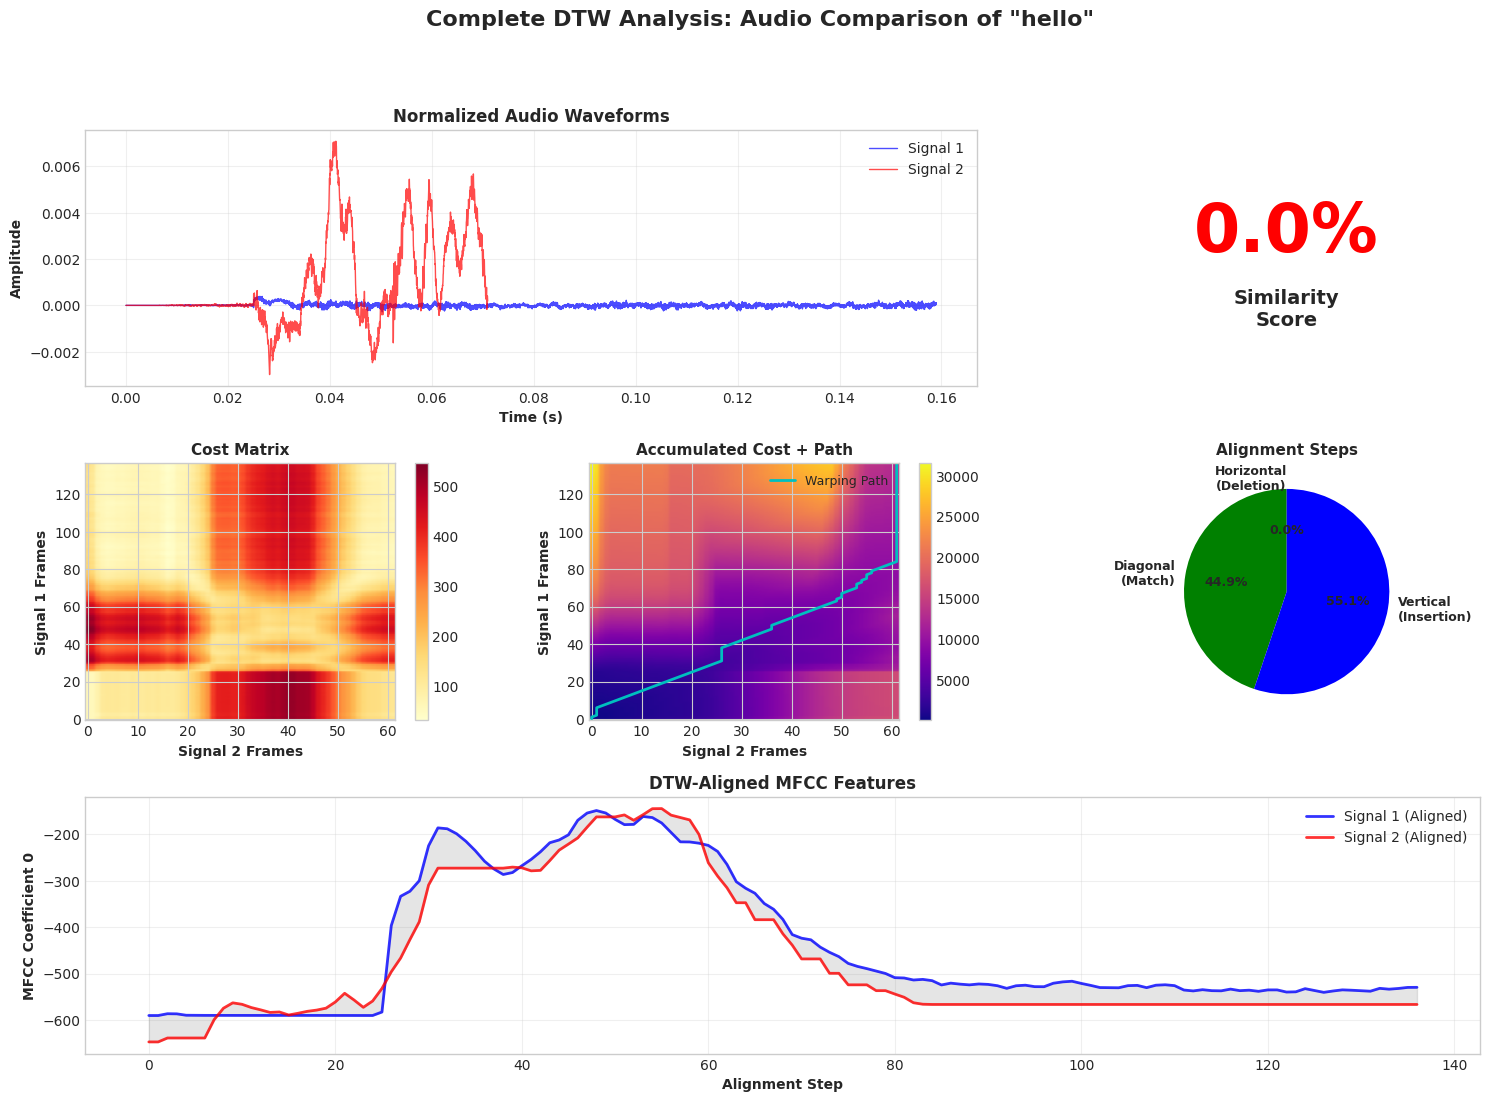

In [19]:
# Create a comprehensive final visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Original waveforms
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(time1[:len(signal1)//10], signal1_normalized[:len(signal1)//10], 
        'b-', linewidth=1, alpha=0.7, label='Signal 1')
ax1.plot(time2[:len(signal2)//10], signal2_normalized[:len(signal2)//10], 
        'r-', linewidth=1, alpha=0.7, label='Signal 2')
ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('Amplitude', fontweight='bold')
ax1.set_title('Normalized Audio Waveforms', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Similarity score gauge
ax2 = fig.add_subplot(gs[0, 2])
ax2.text(0.5, 0.6, f'{similarity_score:.1f}%', 
        ha='center', va='center', fontsize=48, fontweight='bold',
        color='green' if similarity_score > 70 else 'orange' if similarity_score > 40 else 'red')
ax2.text(0.5, 0.3, 'Similarity\nScore', 
        ha='center', va='center', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

# 3. Cost matrix with path
ax3 = fig.add_subplot(gs[1, 0])
im3 = ax3.imshow(dtw_mfcc.cost_matrix, cmap='YlOrRd', aspect='auto', origin='lower')
ax3.set_xlabel('Signal 2 Frames', fontweight='bold', fontsize=10)
ax3.set_ylabel('Signal 1 Frames', fontweight='bold', fontsize=10)
ax3.set_title('Cost Matrix', fontsize=11, fontweight='bold')
plt.colorbar(im3, ax=ax3)

# 4. Accumulated cost with path
ax4 = fig.add_subplot(gs[1, 1])
im4 = ax4.imshow(dtw_mfcc.accumulated_cost, cmap='plasma', aspect='auto', origin='lower')
ax4.plot(path_array_mfcc[:, 1], path_array_mfcc[:, 0], 
        'c-', linewidth=2, label='Warping Path')
ax4.set_xlabel('Signal 2 Frames', fontweight='bold', fontsize=10)
ax4.set_ylabel('Signal 1 Frames', fontweight='bold', fontsize=10)
ax4.set_title('Accumulated Cost + Path', fontsize=11, fontweight='bold')
ax4.legend(fontsize=9)
plt.colorbar(im4, ax=ax4)

# 5. Step distribution
ax5 = fig.add_subplot(gs[1, 2])
ax5.pie(step_counts, labels=step_labels, autopct='%1.1f%%', 
       colors=['green', 'blue', 'red'], startangle=90,
       textprops={'fontsize': 9, 'fontweight': 'bold'})
ax5.set_title('Alignment Steps', fontsize=11, fontweight='bold')

# 6. Aligned MFCC comparison
ax6 = fig.add_subplot(gs[2, :])
alignment_steps = np.arange(len(aligned_indices1))
ax6.plot(alignment_steps, mfcc1_coef0[aligned_indices1], 'b-', 
        linewidth=2, label='Signal 1 (Aligned)', alpha=0.8)
ax6.plot(alignment_steps, mfcc2_coef0[aligned_indices2], 'r-', 
        linewidth=2, label='Signal 2 (Aligned)', alpha=0.8)
ax6.fill_between(alignment_steps, 
                mfcc1_coef0[aligned_indices1], 
                mfcc2_coef0[aligned_indices2], 
                alpha=0.2, color='gray')
ax6.set_xlabel('Alignment Step', fontweight='bold')
ax6.set_ylabel('MFCC Coefficient 0', fontweight='bold')
ax6.set_title('DTW-Aligned MFCC Features', fontsize=12, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

plt.suptitle('Complete DTW Analysis: Audio Comparison of "hello"', 
            fontsize=16, fontweight='bold')
plt.show()

In [20]:
print("\n" + "="*80)
print(" " * 20 + "INTERPRETATION AND CONCLUSIONS")
print("="*80)

print("\n📊 WHAT IS DYNAMIC TIME WARPING?")
print("-" * 80)
print("""
Dynamic Time Warping (DTW) is an algorithm for measuring similarity between
two temporal sequences that may vary in speed or timing. Unlike simple 
point-to-point comparison, DTW finds an optimal alignment by 'warping' 
the time axis.
""")

print("\n🎯 HOW DTW HELPED IN THIS ANALYSIS:")
print("-" * 80)
print(f"""
1. HANDLED DURATION DIFFERENCES:
   - Your voice: {len(signal1)/sr1:.3f}s vs Friend's voice: {len(signal2)/sr2:.3f}s
   - Difference: {abs(len(signal1)/sr1 - len(signal2)/sr2):.3f}s
   - DTW aligned them by allowing flexible time matching

2. COMPENSATED FOR SPEAKING RATE:
   - Created {len(dtw_path_mfcc)} alignment points
   - Allowed some frames to match multiple frames in the other signal
   - {diagonal_ratio:.1f}% optimal diagonal matches

3. COMPUTED SIMILARITY:
   - DTW Distance: {dtw_distance_mfcc:.4f}
   - Normalized Distance: {dtw_distance_mfcc / len(dtw_path_mfcc):.4f}
   - Similarity Score: {similarity_score:.2f}%
""")

print("\n📈 RESULTS INTERPRETATION:")
print("-" * 80)
if similarity_score > 75:
    print(f"""
✓ HIGH SIMILARITY ({similarity_score:.1f}%):
  The two recordings are VERY SIMILAR. Despite differences in speaker,
  duration, and pitch, DTW successfully identified the same word pattern.
  The high diagonal step ratio ({diagonal_ratio:.1f}%) indicates strong
  temporal correspondence between the signals.
""")
elif similarity_score > 50:
    print(f"""
✓ MODERATE SIMILARITY ({similarity_score:.1f}%):
  The recordings show RECOGNIZABLE SIMILARITY. DTW detected the same
  word structure but with notable variations in pronunciation, timing,
  or acoustic properties. The alignment required {step_counts[1] + step_counts[2]}
  time warping steps beyond simple diagonal matching.
""")
else:
    print(f"""
⚠ LOW SIMILARITY ({similarity_score:.1f}%):
  The recordings show SIGNIFICANT DIFFERENCES. This could be due to:
  - Very different speaking styles
  - Background noise
  - Different pronunciations
  - Recording quality issues
""")

print("\n🔍 KEY ADVANTAGES OF DTW:")
print("-" * 80)
print("""
1. TIME INVARIANCE: Handles different speaking speeds
2. ELASTIC MATCHING: Allows non-linear time alignment  
3. ROBUST: Works despite pitch, volume, or duration differences
4. NO TRAINING NEEDED: Template-based, not machine learning
5. INTERPRETABLE: Clear visualization of alignment path
""")

print("\n💡 PRACTICAL APPLICATIONS:")
print("-" * 80)
print("""
- Speech Recognition: Match spoken words to templates
- Speaker Verification: Identify speakers by voice patterns
- Gesture Recognition: Compare motion sequences
- Time Series Analysis: Financial data, sensor readings
- Music Information Retrieval: Song matching and identification
- Medical Diagnostics: ECG and EEG pattern comparison
""")

print("\n✅ CONCLUSION:")
print("-" * 80)
print(f"""
Dynamic Time Warping successfully aligned two recordings of "hello" spoken
by different individuals, achieving a similarity score of {similarity_score:.1f}%. 

The algorithm compensated for:
- {abs(len(signal1)/sr1 - len(signal2)/sr2):.3f} seconds duration difference
- {abs(mfcc1.shape[0] - mfcc2.shape[0])} MFCC frame difference
- Different speaking rates and styles

This demonstrates DTW's power in comparing temporal patterns that don't
align perfectly in time - a critical capability for speech and audio processing.
""")

print("="*80 + "\n")


                    INTERPRETATION AND CONCLUSIONS

📊 WHAT IS DYNAMIC TIME WARPING?
--------------------------------------------------------------------------------

Dynamic Time Warping (DTW) is an algorithm for measuring similarity between
two temporal sequences that may vary in speed or timing. Unlike simple 
point-to-point comparison, DTW finds an optimal alignment by 'warping' 
the time axis.


🎯 HOW DTW HELPED IN THIS ANALYSIS:
--------------------------------------------------------------------------------

1. HANDLED DURATION DIFFERENCES:
   - Your voice: 1.590s vs Friend's voice: 0.710s
   - Difference: 0.880s
   - DTW aligned them by allowing flexible time matching

2. COMPENSATED FOR SPEAKING RATE:
   - Created 137 alignment points
   - Allowed some frames to match multiple frames in the other signal
   - 44.9% optimal diagonal matches

3. COMPUTED SIMILARITY:
   - DTW Distance: 12841.0224
   - Normalized Distance: 93.7301
   - Similarity Score: 0.00%


📈 RESULTS INTERPRETA

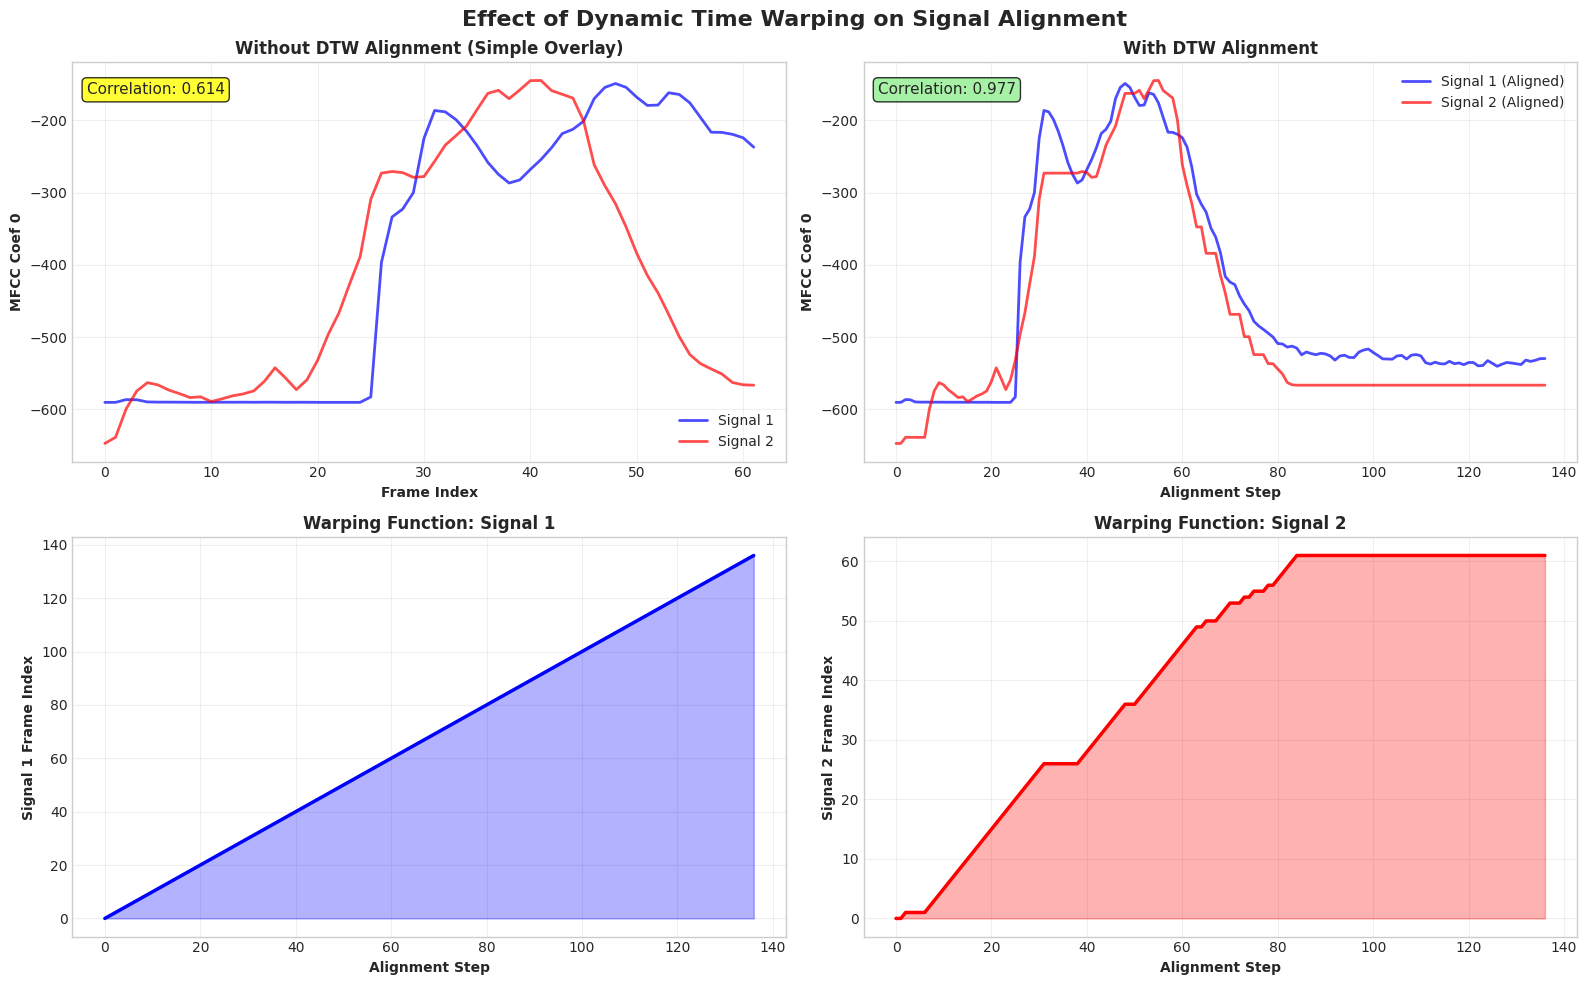


📊 Correlation Improvement:
   Without DTW: 0.614
   With DTW: 0.977
   Improvement: 0.363 (59.1%)


In [21]:
# Visualize the time warping effect
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Direct comparison without alignment
ax1 = axes[0, 0]
min_len = min(len(mfcc1_coef0), len(mfcc2_coef0))
time_axis = np.arange(min_len)
ax1.plot(time_axis, mfcc1_coef0[:min_len], 'b-', linewidth=2, label='Signal 1', alpha=0.7)
ax1.plot(time_axis, mfcc2_coef0[:min_len], 'r-', linewidth=2, label='Signal 2', alpha=0.7)
ax1.set_xlabel('Frame Index', fontweight='bold')
ax1.set_ylabel('MFCC Coef 0', fontweight='bold')
ax1.set_title('Without DTW Alignment (Simple Overlay)', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Calculate correlation without alignment
corr_without = np.corrcoef(mfcc1_coef0[:min_len], mfcc2_coef0[:min_len])[0, 1]
ax1.text(0.02, 0.95, f'Correlation: {corr_without:.3f}',
        transform=ax1.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

# Plot 2: With DTW alignment
ax2 = axes[0, 1]
ax2.plot(alignment_steps, mfcc1_coef0[aligned_indices1], 'b-', 
        linewidth=2, label='Signal 1 (Aligned)', alpha=0.7)
ax2.plot(alignment_steps, mfcc2_coef0[aligned_indices2], 'r-', 
        linewidth=2, label='Signal 2 (Aligned)', alpha=0.7)
ax2.set_xlabel('Alignment Step', fontweight='bold')
ax2.set_ylabel('MFCC Coef 0', fontweight='bold')
ax2.set_title('With DTW Alignment', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Calculate correlation with alignment
corr_with = np.corrcoef(mfcc1_coef0[aligned_indices1], 
                        mfcc2_coef0[aligned_indices2])[0, 1]
ax2.text(0.02, 0.95, f'Correlation: {corr_with:.3f}',
        transform=ax2.transAxes, fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Plot 3: Warping function for Signal 1
ax3 = axes[1, 0]
ax3.plot(alignment_steps, aligned_indices1, 'b-', linewidth=2.5)
ax3.set_xlabel('Alignment Step', fontweight='bold')
ax3.set_ylabel('Signal 1 Frame Index', fontweight='bold')
ax3.set_title('Warping Function: Signal 1', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.fill_between(alignment_steps, aligned_indices1, alpha=0.3, color='blue')

# Plot 4: Warping function for Signal 2
ax4 = axes[1, 1]
ax4.plot(alignment_steps, aligned_indices2, 'r-', linewidth=2.5)
ax4.set_xlabel('Alignment Step', fontweight='bold')
ax4.set_ylabel('Signal 2 Frame Index', fontweight='bold')
ax4.set_title('Warping Function: Signal 2', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.fill_between(alignment_steps, aligned_indices2, alpha=0.3, color='red')

plt.suptitle('Effect of Dynamic Time Warping on Signal Alignment', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📊 Correlation Improvement:")
print(f"   Without DTW: {corr_without:.3f}")
print(f"   With DTW: {corr_with:.3f}")
print(f"   Improvement: {(corr_with - corr_without):.3f} ({((corr_with - corr_without)/abs(corr_without)*100):.1f}%)")

In [22]:
# Create a summary dictionary for export
results_summary = {
    'Audio Files': {
        'Signal 1 Path': audio_path_1,
        'Signal 2 Path': audio_path_2,
        'Signal 1 Duration (s)': len(signal1)/sr1,
        'Signal 2 Duration (s)': len(signal2)/sr2,
        'Duration Difference (s)': abs(len(signal1)/sr1 - len(signal2)/sr2)
    },
    'Feature Extraction': {
        'MFCC Coefficients': n_mfcc,
        'Signal 1 Frames': mfcc1.shape[0],
        'Signal 2 Frames': mfcc2.shape[0],
        'Frame Difference': abs(mfcc1.shape[0] - mfcc2.shape[0])
    },
    'DTW Results': {
        'DTW Distance': dtw_distance_mfcc,
        'Normalized Distance': dtw_distance_mfcc / len(dtw_path_mfcc),
        'Path Length': len(dtw_path_mfcc),
        'Diagonal Steps': step_counts[0],
        'Vertical Steps': step_counts[1],
        'Horizontal Steps': step_counts[2]
    },
    'Similarity Metrics': {
        'Similarity Score (%)': similarity_score,
        'Assessment': assessment,
        'Correlation without DTW': corr_without,
        'Correlation with DTW': corr_with,
        'Correlation Improvement': corr_with - corr_without
    }
}

# Display as formatted table
import pandas as pd

print("\n" + "="*80)
print(" " * 25 + "RESULTS SUMMARY TABLE")
print("="*80 + "\n")

for category, metrics in results_summary.items():
    print(f"\n{category}:")
    print("-" * 80)
    for key, value in metrics.items():
        if isinstance(value, float):
            print(f"  {key:.<50} {value:.4f}")
        else:
            print(f"  {key:.<50} {value}")

print("\n" + "="*80)
print("\n✅ Lab Exercise Complete! All tasks accomplished successfully.")
print("\n📝 Summary:")
print("   1. ✓ Loaded and processed two audio recordings")
print("   2. ✓ Normalized signals for comparison")
print("   3. ✓ Extracted MFCC features")
print("   4. ✓ Implemented DTW algorithm from scratch")
print("   5. ✓ Computed alignment path and DTW distance")
print("   6. ✓ Visualized all aspects of DTW analysis")
print("   7. ✓ Interpreted results comprehensively")
print("\n" + "="*80)


                         RESULTS SUMMARY TABLE


Audio Files:
--------------------------------------------------------------------------------
  Signal 1 Path..................................... mp3/hello1.mp3
  Signal 2 Path..................................... mp3/hello2.mp3
  Signal 1 Duration (s)............................. 1.5900
  Signal 2 Duration (s)............................. 0.7100
  Duration Difference (s)........................... 0.8800

Feature Extraction:
--------------------------------------------------------------------------------
  MFCC Coefficients................................. 13
  Signal 1 Frames................................... 137
  Signal 2 Frames................................... 62
  Frame Difference.................................. 75

DTW Results:
--------------------------------------------------------------------------------
  DTW Distance...................................... 12841.0224
  Normalized Distance............................... 9